In [1]:
import sys
sys.path.insert(0, '../scanpy')

%load_ext autoreload
%autoreload 2
import paths_get as get

/usr/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


This notebook contains a basic overview of a multimodal workflow in current (master branch) scanpy

In [2]:
import scanpy as sc
import pandas as pd

import seaborn as sns
import matplotlib as mpl

# Reading in multimodal data is pretty easy

In [3]:
!mkdir -p data
!cd data && wget -N http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5

--2020-03-18 13:25:54--  http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5
Auflösen des Hostnamens cf.10xgenomics.com (cf.10xgenomics.com)… 2600:9000:21a1:3a00:1d:87c0:ff40:93a1, 2600:9000:21a1:5000:1d:87c0:ff40:93a1, 2600:9000:21a1:9600:1d:87c0:ff40:93a1, ...
Verbindungsaufbau zu cf.10xgenomics.com (cf.10xgenomics.com)|2600:9000:21a1:3a00:1d:87c0:ff40:93a1|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 304 Not Modified
Datei »5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5« auf dem Server unverändert. Wird nicht heruntergeladen.


In [4]:
DATAFILE = "data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"

In [5]:
pbmc = sc.read_10x_h5(DATAFILE, gex_only=False)
pbmc

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5527 × 33570 
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing and normalization

Split into protein and gene objects:

In [6]:
protein = pbmc[:, pbmc.var["genome"] == ""].copy()
genes = pbmc[:, pbmc.var["genome"] != ""].copy()

genes.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Protein

In [7]:
protein.var["control"] = protein.var_names.str.contains("control")

In [8]:
sc.pp.calculate_qc_metrics(
    protein,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    qc_vars=("control",),
    inplace=True,
)

 We can look at qc stuff:

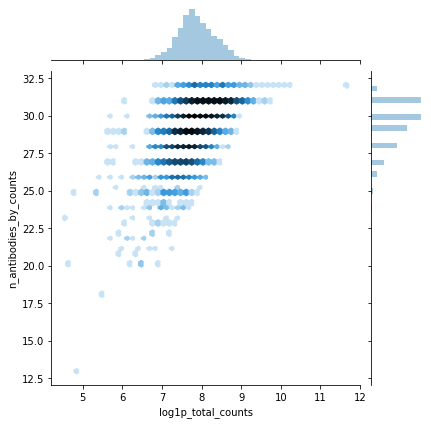

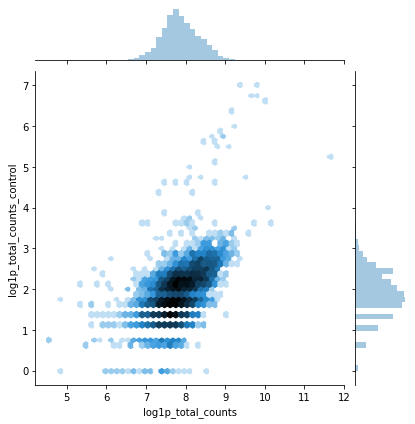

In [9]:
sns.jointplot("log1p_total_counts", "n_antibodies_by_counts", protein.obs, kind="hex", norm=mpl.colors.LogNorm())
sns.jointplot("log1p_total_counts", "log1p_total_counts_control", protein.obs, kind="hex", norm=mpl.colors.LogNorm())

In [10]:
protein.layers["counts"] = protein.X.copy()

In [11]:
sc.pp.normalize_geometric(protein)
sc.pp.log1p(protein)

In [12]:
sc.pp.pca(protein, n_comps=20)
sc.pp.neighbors(protein, use_rep="X", metric="cosine")  # There's only 32 antibodies, so might as well
sc.tl.umap(protein)
sc.tl.leiden(protein)

/usr/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/lib/python3.8/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  candidate_neighbors = build_candidates(
/usr/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/lib/python3.8/site-packages/umap/nndescent.py", line 47:
 

... storing 'feature_types' as categorical
... storing 'genome' as categorical


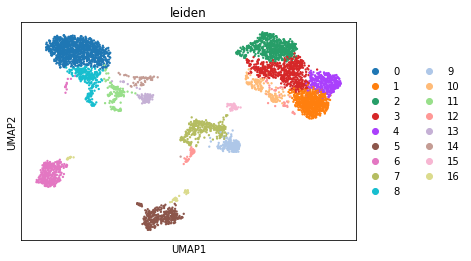

In [13]:
sc.pl.umap(protein, color="leiden")

In [14]:
protein

AnnData object with n_obs × n_vars = 5527 × 32 
    obs: 'n_antibodies_by_counts', 'log1p_n_antibodies_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_5_antibodies', 'pct_counts_in_top_10_antibodies', 'pct_counts_in_top_15_antibodies', 'total_counts_control', 'log1p_total_counts_control', 'pct_counts_control', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

### RNA

Preprocess

In [15]:
genes.var["mito"] = genes.var_names.str.startswith("MT-")

In [16]:
sc.pp.filter_genes(genes, min_counts=1)
sc.pp.calculate_qc_metrics(genes, qc_vars=["mito"], inplace=True)

In [17]:
# Cache counts
genes.layers["counts"] = genes.X.copy()

In [18]:
sc.pp.normalize_total(genes)
sc.pp.log1p(genes)

In [19]:
sc.pp.pca(genes)
sc.pp.neighbors(genes, n_neighbors=30)
sc.tl.umap(genes)
sc.tl.leiden(genes)

# Joining the data and doing some plotting

In [20]:
genes.obsm["protein"] = protein.to_df()
genes.obsm["protein_umap"] = protein.obsm["X_umap"]
genes.obs["protein_leiden"] = protein.obs["leiden"]

The clusterings disagree quite a bit, so we can tell that we are missing some information:

... storing 'feature_types' as categorical
... storing 'genome' as categorical


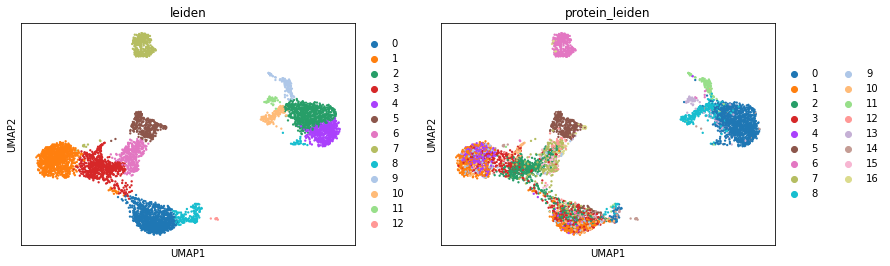

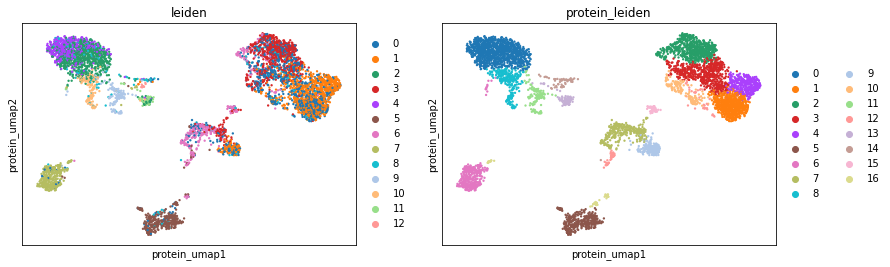

In [21]:
sc.pl.umap(genes, color=["leiden", "protein_leiden"])
sc.pl.embedding(genes, basis="protein_umap", color=["leiden", "protein_leiden"])

## Plotting values between modalities

* TODO: Get selectors like this working in scanpy.

### Imports and helper functions

In [22]:
import altair as alt
from functools import partial

alt.renderers.enable("png")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [23]:
def embedding_chart(df: pd.DataFrame, coord_pat: str, *, size=5) -> alt.Chart:
    """Make schema for coordinates, like sc.pl.embedding."""
    x, y = df.columns[df.columns.str.contains(coord_pat)]
    return (
        alt.Chart(plotdf, height=300, width=300)
        .mark_circle(size=size)
        .encode(
            x=alt.X(x, axis=None),
            y=alt.Y(y, axis=None),
        )
    )

def umap_chart(df: pd.DataFrame, **kwargs) -> alt.Chart:
    """Like sc.pl.umap, but just the coordinates."""
    return embedding_chart(df, "umap", **kwargs)

def encode_color(c: alt.Chart, col: str, *, qdomain=(0, 1), scheme: str = "lightgreyred") -> alt.Chart:
    """Add colors to an embedding plot schema."""
    base = c.properties(title=col)
    if pd.api.types.is_categorical(c.data[col]):
        return base.encode(color=col)
    else:
        return base.encode(
            color=alt.Color(
                col,
                scale=alt.Scale(
                    scheme=scheme,
                    clamp=True,
                    domain=list(c.data[col].quantile(qdomain)),
                    nice=True,
                )
            )
        )

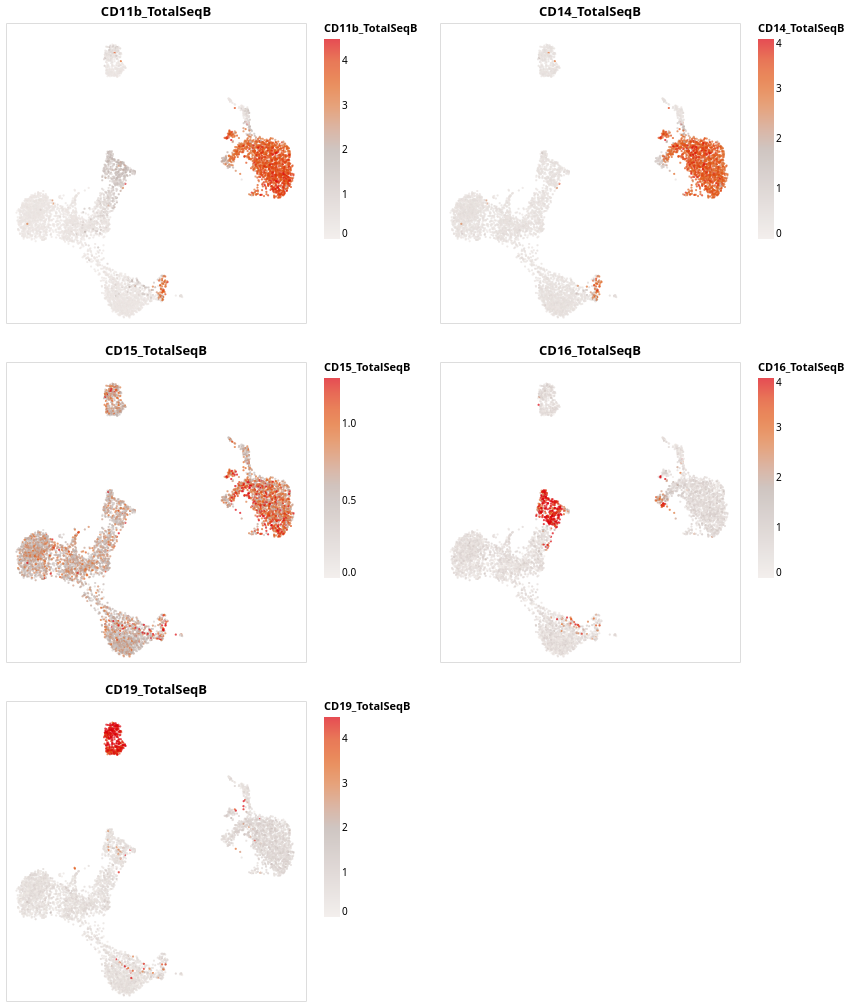

In [32]:
plotdf = get.obs_df(
    genes,
    [f"obsm/X_umap/{i}" for i in range(2)] + [f"obsm/protein/{i}" for i in genes.obsm["protein"].columns]
)
c = umap_chart(plotdf)
(
    alt.concat(
        *map(partial(encode_color, c, qdomain=(0, .95)), plotdf.columns[5:10]),
        columns=2
    )
    .resolve_scale(color='independent')
    .configure_axis(grid=False)
)

# Integration ideas

## Joint clustering

So far I've only gotten okay results from this, but also haven't followed up on it much:

In [33]:
genes.obsp["protein_connectivities"] = protein.obsp["connectivities"]

KeyError: 'connectivities'

In [ ]:
sc.tl.leiden_multiplex(genes, ["connectivities", "protein_connectivities"])

As you can see, looks only okay. I think it'd be worth doing some feature selection as well as doublet removal and trying again.

KeyError: 'leiden_multiplex'

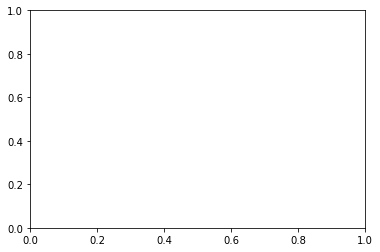

In [34]:
sc.pl.umap(genes, color="leiden_multiplex")
sc.pl.embedding(genes, basis="protein_umap", color="leiden_multiplex")

In [35]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["leiden"], normalize="index"))

KeyError: 'leiden_multiplex'

In [36]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["protein_leiden"], normalize="index"))

KeyError: 'leiden_multiplex'